# Steps: 
1. Determine which variables to use
2. Cut down size of dataframe (maybe top 10 and do dummies? or an aggregate (# of pitbulls per month)
3. Create multivariate dataframe, including timestamp index
4. Scale, series_to_supervise
5. Fit data, split to train_test sets
6. Use univariate LSTM, tune to lowest MSE
7. Compare univariate to multivariate scores, make analysis
8. Save model and fit into function
9. Write new prediction function? 
10. Conclude, interpret
11. Make more visualizations
12. Blog about it
13. Where do we go from here? 
14. What is the "so what"? 

In [55]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import table
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import time
import datetime
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
import numpy as np

In [2]:
#file path for data: capstone/using-AI-to-predict-dog-licenses/data
#open raw_data.csv

In [3]:
df = pd.read_csv('raw_data.csv')

In [4]:
df.set_index('ValidDate', inplace = True)

In [5]:
df = df.drop(['ExpYear'], axis = 1)

In [6]:
df.head()

,LicenseType,Breed,Color,DogName,OwnerZip
ValidDate,,,,,
2014-12-02 09:40:53,Dog Individual Neutered Male,COCKAPOO,BROWN,CHARLEY,15236
2014-12-02 09:45:25,Dog Senior Citizen or Disability Neutered Male,GER SHEPHERD,BLACK/BROWN,TACODA,15238
2014-12-02 09:47:55,Dog Individual Spayed Female,GER SHEPHERD,BLACK,CHARLY,15205
2014-12-02 10:02:33,Dog Individual Spayed Female,LABRADOR RETRIEVER,BLACK,ABBEY,15143
2014-12-02 10:05:50,Dog Individual Female,GER SHORTHAIR POINT,BROWN,CHARLEY,15228


In [7]:
df['Breed'].value_counts().sum()

286724

In [8]:
len(df['Breed'].unique())

340

In [9]:
#I would definitely need to look at cutting that number down- that would be way too noisy.
#My initial thought is to see what the top 10 breeds are
#Maybe from there I can either to dummies or aggregate

In [10]:
top_ten = df['Breed'].value_counts()[:11]

In [11]:
top_ten
#bar chart here

MIXED                  29009
LABRADOR RETRIEVER     19713
LAB MIX                17714
GOLDEN RETRIEVER        9344
GER SHEPHERD            8437
SHIH TZU                7976
BEAGLE                  7960
CHIHUAHUA               7664
TAG                     7475
AM PIT BULL TERRIER     7332
YORKSHIRE TERRIER       6268
Name: Breed, dtype: int64

In [12]:
#TAG is not a type of dog. they are denoting that they are putting tags on an existing dog

In [13]:
tag_df = df.loc[df['Breed'] == 'TAG']
tag_df.loc[(tag_df['DogName'] == 'SHADOW') & (tag_df['OwnerZip'] == 15102)]

,LicenseType,Breed,Color,DogName,OwnerZip
ValidDate,,,,,
2015-03-12 11:11:36,Dog Individual Spayed Female,TAG,BLACK,SHADOW,15102
2017-01-10 09:39:46,Dog Individual Spayed Female,TAG,BLACK,SHADOW,15102
2015-12-11 10:35:08,Dog Individual Spayed Female,TAG,BLACK,SHADOW,15102


In [14]:
a = len(tag_df['DogName'])
b = len(tag_df['DogName'].value_counts())
a-b

5708

In [15]:
#Time to zoom out. What am i hoping to accomplish here? 
#A multivariate time series. OG problem: predict number of licenses dispensed per day. 
#New problem: predict licenses dispenses while considering extra variables. 
#I think top 10 dummies is actually going to benefit me most. 
#Let's start with breed: top 9 and 'other'
## investigate whether an 'other' column is going to unbalance the data too bad; 
#we may need to keep it to top 10 with a disclaimer

In [16]:
df.head()

,LicenseType,Breed,Color,DogName,OwnerZip
ValidDate,,,,,
2014-12-02 09:40:53,Dog Individual Neutered Male,COCKAPOO,BROWN,CHARLEY,15236
2014-12-02 09:45:25,Dog Senior Citizen or Disability Neutered Male,GER SHEPHERD,BLACK/BROWN,TACODA,15238
2014-12-02 09:47:55,Dog Individual Spayed Female,GER SHEPHERD,BLACK,CHARLY,15205
2014-12-02 10:02:33,Dog Individual Spayed Female,LABRADOR RETRIEVER,BLACK,ABBEY,15143
2014-12-02 10:05:50,Dog Individual Female,GER SHORTHAIR POINT,BROWN,CHARLEY,15228


In [17]:
df.isnull().sum()

LicenseType    0
Breed          0
Color          0
DogName        0
OwnerZip       0
dtype: int64

In [18]:
breed_df = pd.DataFrame(df.Breed)
breed_df.set_index(breed_df.index, inplace = True)
breed_df.index = pd.to_datetime(breed_df.index)

MIXED
LABRADOR RETRIEVER     
LAB MIX                
GOLDEN RETRIEVER        
GER SHEPHERD            
SHIH TZU            
BEAGLE                  
CHIHUAHUA                                  
AM PIT BULL TERRIER     
YORKSHIRE TERRIER      

In [19]:
df_top_ten = breed_df[(breed_df['Breed'] == 'MIXED') |
                     (breed_df['Breed'] == 'LABRADOR RETRIEVER') |
                     (breed_df['Breed'] == 'LAB MIX') |
                     (breed_df['Breed'] == 'GOLDEN RETRIEVER') |
                     (breed_df['Breed'] == 'GER SHEPHERD') |
                     (breed_df['Breed'] == 'SHIH TZU') |
                     (breed_df['Breed'] == 'BEAGLE') |
                     (breed_df['Breed'] == 'CHIHUAHUA') |
                     (breed_df['Breed'] == 'AM PIT BULL TERRIER')|
                     (breed_df['Breed'] == 'YORKSHIRE TERRIER')]
df_top_ten.head()

,Breed
ValidDate,
2014-12-02 09:45:25,GER SHEPHERD
2014-12-02 09:47:55,GER SHEPHERD
2014-12-02 10:02:33,LABRADOR RETRIEVER
2014-12-02 10:08:13,YORKSHIRE TERRIER
2014-12-02 10:15:30,YORKSHIRE TERRIER


In [20]:
print("Breed df: ", len(breed_df))
print("Top Ten df: ", len(df_top_ten))
print("Difference: ", len(breed_df)-len(df_top_ten))

Breed df:  286724
Top Ten df:  121417
Difference:  165307


In [21]:
ten_dummies = pd.get_dummies(df_top_ten['Breed'])
ten_dummies.head()

,AM PIT BULL TERRIER,BEAGLE,CHIHUAHUA,GER SHEPHERD,GOLDEN RETRIEVER,LAB MIX,LABRADOR RETRIEVER,MIXED,SHIH TZU,YORKSHIRE TERRIER
ValidDate,,,,,,,,,,
2014-12-02 09:45:25,0,0,0,1,0,0,0,0,0,0
2014-12-02 09:47:55,0,0,0,1,0,0,0,0,0,0
2014-12-02 10:02:33,0,0,0,0,0,0,1,0,0,0
2014-12-02 10:08:13,0,0,0,0,0,0,0,0,0,1
2014-12-02 10:15:30,0,0,0,0,0,0,0,0,0,1


In [22]:
breed = ten_dummies.resample('B').sum()
breed.head()

,AM PIT BULL TERRIER,BEAGLE,CHIHUAHUA,GER SHEPHERD,GOLDEN RETRIEVER,LAB MIX,LABRADOR RETRIEVER,MIXED,SHIH TZU,YORKSHIRE TERRIER
ValidDate,,,,,,,,,,
2014-12-02,2.0,1.0,1.0,4.0,2.0,3.0,9.0,10.0,1.0,3.0
2014-12-03,6.0,8.0,2.0,3.0,8.0,17.0,12.0,40.0,2.0,3.0
2014-12-04,5.0,7.0,2.0,7.0,17.0,17.0,29.0,51.0,12.0,13.0
2014-12-05,4.0,2.0,5.0,2.0,9.0,10.0,10.0,21.0,5.0,3.0
2014-12-08,5.0,5.0,8.0,11.0,9.0,14.0,23.0,47.0,8.0,10.0


In [23]:
breed['Total'] = breed.sum(axis = 1)
breed.head()

,AM PIT BULL TERRIER,BEAGLE,CHIHUAHUA,GER SHEPHERD,GOLDEN RETRIEVER,LAB MIX,LABRADOR RETRIEVER,MIXED,SHIH TZU,YORKSHIRE TERRIER,Total
ValidDate,,,,,,,,,,,
2014-12-02,2.0,1.0,1.0,4.0,2.0,3.0,9.0,10.0,1.0,3.0,36.0
2014-12-03,6.0,8.0,2.0,3.0,8.0,17.0,12.0,40.0,2.0,3.0,101.0
2014-12-04,5.0,7.0,2.0,7.0,17.0,17.0,29.0,51.0,12.0,13.0,160.0
2014-12-05,4.0,2.0,5.0,2.0,9.0,10.0,10.0,21.0,5.0,3.0,71.0
2014-12-08,5.0,5.0,8.0,11.0,9.0,14.0,23.0,47.0,8.0,10.0,140.0


In [24]:
breed.to_csv('breed_daily_totals.csv')

In [25]:
#next I would like to get a pretty visualization of this- a colorful line chart

In [26]:
#run model on just top 10, determine the importance of dog breed in prediction
#if it's highly correlated, consider 'other' column, or even 340 dummies? 

## Scaling Data

In [27]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(breed.values)

series_to_supervise function courtesy of Jason Brownlee with Machine Learning Mastery

In [28]:
def series_to_supervise(data, n_in = 1, n_out = 1, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d' % (j+1)) for j in range(n_vars)]
        else: 
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace = True)
    return agg

In [29]:
#start with lag of 1
lstm_df = series_to_supervise(scaled_df)
lstm_df.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11
1,0.018018,0.004831,0.007194,0.023256,0.008475,0.007812,0.020045,0.012690,0.005128,0.019737,0.013025,0.054054,0.038647,0.014388,0.017442,0.033898,0.044271,0.026726,0.050761,0.010256,0.019737,0.036541
2,0.054054,0.038647,0.014388,0.017442,0.033898,0.044271,0.026726,0.050761,0.010256,0.019737,0.036541,0.045045,0.033816,0.014388,0.040698,0.072034,0.044271,0.064588,0.064721,0.061538,0.085526,0.057887
3,0.045045,0.033816,0.014388,0.040698,0.072034,0.044271,0.064588,0.064721,0.061538,0.085526,0.057887,0.036036,0.009662,0.035971,0.011628,0.038136,0.026042,0.022272,0.026650,0.025641,0.019737,0.025687
4,0.036036,0.009662,0.035971,0.011628,0.038136,0.026042,0.022272,0.026650,0.025641,0.019737,0.025687,0.045045,0.024155,0.057554,0.063953,0.038136,0.036458,0.051225,0.059645,0.041026,0.065789,0.050651
5,0.045045,0.024155,0.057554,0.063953,0.038136,0.036458,0.051225,0.059645,0.041026,0.065789,0.050651,0.054054,0.028986,0.014388,0.040698,0.029661,0.010417,0.026726,0.020305,0.015385,0.013158,0.023517


In [30]:
lstm_df.columns

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)',
       'var11(t-1)', 'var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7',
       'var8', 'var9', 'var10', 'var11'],
      dtype='object')

In [31]:
lstm_df.drop(lstm_df.columns[[11, 12, 13, 14, 15, 16, 17, 18, 19, 20]], axis = 1, inplace = True)
lstm_df.columns

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)',
       'var11(t-1)', 'var11'],
      dtype='object')

In [32]:
#train_test_split
X = lstm_df[lstm_df.columns[:10]].values
y = lstm_df['var11'].values

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [34]:
print("X_train: ",X_train.shape)
print("X_test: ", X_test.shape)
print("Y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (727, 10)
X_test:  (312, 10)
Y_train:  (727,)
y_test:  (312,)


In [35]:
#Reshape into a 3D that LSTM expects
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape)
print(X_test.shape)

(727, 1, 10)
(312, 1, 10)


In [36]:
#Because I have already done the work of optimizing the sum for LSTM, I'll use the optimal model from the univariate
#I can always go back and tune further
#This does mean I will have to adjust the data to 5 lags

In [37]:
lag_5 = series_to_supervise(scaled_df, 5, 1)
lag_5.head()

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var9(t-5),var10(t-5),var11(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var7(t-4),var8(t-4),var9(t-4),var10(t-4),var11(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),var11(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),var11(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11
5,0.018018,0.004831,0.007194,0.023256,0.008475,0.007812,0.020045,0.012690,0.005128,0.019737,0.013025,0.054054,0.038647,0.014388,0.017442,0.033898,0.044271,0.026726,0.050761,0.010256,0.019737,0.036541,0.045045,0.033816,0.014388,0.040698,0.072034,0.044271,0.064588,0.064721,0.061538,0.085526,0.057887,0.036036,0.009662,0.035971,0.011628,0.038136,0.026042,0.022272,0.026650,0.025641,0.019737,0.025687,0.045045,0.024155,0.057554,0.063953,0.038136,0.036458,0.051225,0.059645,0.041026,0.065789,0.050651,0.054054,0.028986,0.014388,0.040698,0.029661,0.010417,0.026726,0.020305,0.015385,0.013158,0.023517
6,0.054054,0.038647,0.014388,0.017442,0.033898,0.044271,0.026726,0.050761,0.010256,0.019737,0.036541,0.045045,0.033816,0.014388,0.040698,0.072034,0.044271,0.064588,0.064721,0.061538,0.085526,0.057887,0.036036,0.009662,0.035971,0.011628,0.038136,0.026042,0.022272,0.026650,0.025641,0.019737,0.025687,0.045045,0.024155,0.057554,0.063953,0.038136,0.036458,0.051225,0.059645,0.041026,0.065789,0.050651,0.054054,0.028986,0.014388,0.040698,0.029661,0.010417,0.026726,0.020305,0.015385,0.013158,0.023517,0.036036,0.009662,0.007194,0.005814,0.012712,0.013021,0.013363,0.013959,0.010256,0.013158,0.013386
7,0.045045,0.033816,0.014388,0.040698,0.072034,0.044271,0.064588,0.064721,0.061538,0.085526,0.057887,0.036036,0.009662,0.035971,0.011628,0.038136,0.026042,0.022272,0.026650,0.025641,0.019737,0.025687,0.045045,0.024155,0.057554,0.063953,0.038136,0.036458,0.051225,0.059645,0.041026,0.065789,0.050651,0.054054,0.028986,0.014388,0.040698,0.029661,0.010417,0.026726,0.020305,0.015385,0.013158,0.023517,0.036036,0.009662,0.007194,0.005814,0.012712,0.013021,0.013363,0.013959,0.010256,0.013158,0.013386,0.054054,0.000000,0.000000,0.023256,0.029661,0.020833,0.020045,0.013959,0.020513,0.006579,0.018090
8,0.036036,0.009662,0.035971,0.011628,0.038136,0.026042,0.022272,0.026650,0.025641,0.019737,0.025687,0.045045,0.024155,0.057554,0.063953,0.038136,0.036458,0.051225,0.059645,0.041026,0.065789,0.050651,0.054054,0.028986,0.014388,0.040698,0.029661,0.010417,0.026726,0.020305,0.015385,0.013158,0.023517,0.036036,0.009662,0.007194,0.005814,0.012712,0.013021,0.013363,0.013959,0.010256,0.013158,0.013386,0.054054,0.000000,0.000000,0.023256,0.029661,0.020833,0.020045,0.013959,0.020513,0.006579,0.018090,0.045045,0.009662,0.021583,0.023256,0.012712,0.015625,0.011136,0.011421,0.010256,0.013158,0.014834
9,0.045045,0.024155,0.057554,0.063953,0.038136,0.036458,0.051225,0.059645,0.041026,0.065789,0.050651,0.054054,0.028986,0.014388,0.040698,0.029661,0.010417,0.026726,0.020305,0.015385,0.013158,0.023517,0.036036,0.009662,0.007194,0.005814,0.012712,0.013021,0.013363,0.013959,0.010256,0.013158,0.013386,0.054054,0.000000,0.000000,0.023256,0.029661,0.020833,0.020045,0.013959,0.020513,0.006579,0.018090,0.045045,0.009662,0.021583,0.023256,0.012712,0.015625,0.011136,0.011421,0.010256,0.013158,0.014834,0.063063,0.019324,0.007194,0.011628,0.016949,0.018229,0.006682,0.020305,0.010256,0.013158,0.017366


In [38]:
lag_5.columns

Index(['var1(t-5)', 'var2(t-5)', 'var3(t-5)', 'var4(t-5)', 'var5(t-5)',
       'var6(t-5)', 'var7(t-5)', 'var8(t-5)', 'var9(t-5)', 'var10(t-5)',
       'var11(t-5)', 'var1(t-4)', 'var2(t-4)', 'var3(t-4)', 'var4(t-4)',
       'var5(t-4)', 'var6(t-4)', 'var7(t-4)', 'var8(t-4)', 'var9(t-4)',
       'var10(t-4)', 'var11(t-4)', 'var1(t-3)', 'var2(t-3)', 'var3(t-3)',
       'var4(t-3)', 'var5(t-3)', 'var6(t-3)', 'var7(t-3)', 'var8(t-3)',
       'var9(t-3)', 'var10(t-3)', 'var11(t-3)', 'var1(t-2)', 'var2(t-2)',
       'var3(t-2)', 'var4(t-2)', 'var5(t-2)', 'var6(t-2)', 'var7(t-2)',
       'var8(t-2)', 'var9(t-2)', 'var10(t-2)', 'var11(t-2)', 'var1(t-1)',
       'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)',
       'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)', 'var11(t-1)',
       'var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7', 'var8', 'var9',
       'var10', 'var11'],
      dtype='object')

In [39]:
lag_5.drop(lag_5.columns[[55, 56, 57, 58, 59, 60, 61, 62, 63, 64]], axis = 1, inplace = True)
lag_5.columns

Index(['var1(t-5)', 'var2(t-5)', 'var3(t-5)', 'var4(t-5)', 'var5(t-5)',
       'var6(t-5)', 'var7(t-5)', 'var8(t-5)', 'var9(t-5)', 'var10(t-5)',
       'var11(t-5)', 'var1(t-4)', 'var2(t-4)', 'var3(t-4)', 'var4(t-4)',
       'var5(t-4)', 'var6(t-4)', 'var7(t-4)', 'var8(t-4)', 'var9(t-4)',
       'var10(t-4)', 'var11(t-4)', 'var1(t-3)', 'var2(t-3)', 'var3(t-3)',
       'var4(t-3)', 'var5(t-3)', 'var6(t-3)', 'var7(t-3)', 'var8(t-3)',
       'var9(t-3)', 'var10(t-3)', 'var11(t-3)', 'var1(t-2)', 'var2(t-2)',
       'var3(t-2)', 'var4(t-2)', 'var5(t-2)', 'var6(t-2)', 'var7(t-2)',
       'var8(t-2)', 'var9(t-2)', 'var10(t-2)', 'var11(t-2)', 'var1(t-1)',
       'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)',
       'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)', 'var11(t-1)',
       'var11'],
      dtype='object')

In [40]:
len(lag_5.columns)

56

In [41]:
X_5 = lag_5[lag_5.columns[:55]].values
y_5 = lag_5['var11'].values

In [92]:
X5_train, X5_test, y5_train, y5_test = train_test_split(X_5, y_5, test_size = 0.3, random_state = 42)

In [93]:
print("X5_train: ",X5_train.shape)
print("X5_test: ", X5_test.shape)
print("Y5_train: ", y5_train.shape)
print("y5_test: ", y5_test.shape)

X5_train:  (724, 55)
X5_test:  (311, 55)
Y5_train:  (724,)
y5_test:  (311,)


In [94]:
X5_train = X5_train.reshape((X5_train.shape[0], 5, 11))
X5_test = X5_test.reshape((X5_test.shape[0], 5, 11))
print(X5_train.shape)
print(X5_test.shape)

(724, 5, 11)
(311, 5, 11)


In [95]:
#same model from univariate experiment
now = datetime.datetime.now()
model_5 = Sequential()
model_5.add(LSTM(50, input_shape = (X5_train.shape[1], X5_train.shape[2])))
model_5.add(Dense(50, activation = 'tanh'))
model_5.add(Dropout(0.3))
model_5.add(Dense(35, activation = 'tanh'))
model_5.add(Dropout(0.3))
model_5.add(Dense(20, activation = 'tanh'))
model_5.add(Dropout(0.3))
model_5.add(Dense(1))
model_5.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse'])

history_5 = model_5.fit(X5_train, y5_train, epochs = 10, batch_size = 20, validation_data = (X5_test, y5_test),
                        verbose = True, shuffle = False)
later = datetime.datetime.now()
elapsed = later - now
print('Time elapsed: ', elapsed)

Epoch 1/10
37/37 [==============================] - 2s 18ms/step - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 2/10
37/37 [==============================] - 0s 6ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 3/10
37/37 [==============================] - 0s 6ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 4/10
37/37 [==============================] - 0s 5ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 5/10
37/37 [==============================] - 0s 6ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 6/10
37/37 [==============================] - 0s 6ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 7/10
37/37 [==============================] - 0s 6ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 8/10
37/37 [==============================] - 0s 6ms/step - loss: 0.0042 - mse: 0.0

In [46]:
#examine and analyze these results- let's see what's up!

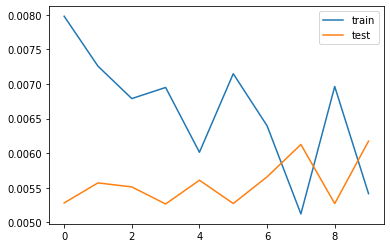

In [96]:
plt.plot(history_5.history['loss'], label = 'train')
plt.plot(history_5.history['val_loss'], label = 'test')
plt.legend()
plt.show()

In [99]:
#making predictions 
yhat = model_5.predict(X5_test)
X5_test = X5_test.reshape((X5_test.shape[0], 55))
inv_yhat = np.concatenate((yhat, X5_test[:, -10:]), axis = 1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]

y5_test = y5_test.reshape((len(y5_test), 1))
inv_y = np.concatenate((y5_test, X5_test[:, -10:]), axis = 1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

mse = mean_squared_error(inv_y, inv_yhat)
print('MSE of prediction: ', np.round(mse, 2))

MSE of prediction:  76.07


In [75]:
#daaaaaaang

1555.0

Just for fun- let's see what happens when we use the recursive function

In [100]:
#Create output df
output = pd.DataFrame({'Valid Date': pd.date_range(start = '2017-12-22', end = '2018-12-20', freq = 'B')})
output = output[(output['Valid Date'] != '2017-12-25') &
                (output['Valid Date'] != '2018-01-01') &
                (output['Valid Date'] != '2018-01-15') &
                (output['Valid Date'] != '2018-02-19') &
                (output['Valid Date'] != '2018-05-28') &
                (output['Valid Date'] != '2018-07-04') &
                (output['Valid Date'] != '2018-09-03') &
                (output['Valid Date'] != '2018-11-12') &
                (output['Valid Date'] != '2018-11-22')]

In [106]:
#attempt using predict_values function from univariate model
def predict_values(training_data, output):
  ''' A function that takes in training data and uses a tuned LSTM neural 
  network to recursively predict data for a given number of steps.

  Inputs: training_data: The last 5 points of the models training set
    output: user provided dataframe formatted with a desired time period to be predicted
    as a pd.TimeStamp 
  Returns: The output parameter with a scaled prediction and unscaled prediction column 
  appended'''

  predictions = []
  predictions.append(training_data)
  x_array = np.array(predictions)
  #ammend function to intake number of input variables
  x_array = x_array.reshape(1, 5, 1)
#Generate predictions
  model = model_5
  for n in range(len(output)):
    pred = model.predict(x_array)
    x_array = np.append(x_array, pred)
    predictions.append(pred)

    x_array = x_array[-5:].reshape(1, 5, 1)

#Add predictions to output df, unlist the values
  predictions = predictions[1:]
  pred_list = []
  for n in range(len(output)):
    pred_list.append(predictions[n].tolist())

  unlisted = []
  for n in range(len(pred_list)):
    var = pred_list[n]
    var = var[0]
    unlisted.append(var)

  output['Scaled Prediction'] = unlisted

#Unscale predicted value
  unlisted_array = np.array(unlisted)
  unlisted_array = unlisted_array.reshape(-1, 1)
  output['Predicted Value'] = scaler.inverse_transform(unlisted_array)

  return output

In [105]:
X5_train[-5:].shape

(5, 5, 11)

In [107]:
year_one = predict_values(X5_train[-5:], output)

ValueError: ignored

In [111]:
predictions = []
predictions.append(X5_train[-5:])
x_array = np.array(predictions)
print(x_array.shape)
# #ammend function to intake number of input variables
# x_array = x_array.reshape(1, 5, 1)

(1, 5, 5, 11)


In [113]:
print(X5_train[-5:].shape)

(5, 5, 11)
